<font size=6>使用TensorFlow训练Boosted Trees model</font>

这篇tutorial适用tf.estimator完整的训练一个Gradient Boosting Decision Tree(GBDT)模型。
Boosted Tree是非常流行且有用的分类和回归模型，它使用集成技术将多棵树的预测结果整合成一个结果值。
<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#titanic数据集处理" data-toc-modified-id="titanic数据集处理-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>titanic数据集处理</a></span><ul class="toc-item"><li><span><a href="#加载数据集" data-toc-modified-id="加载数据集-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>加载数据集</a></span></li><li><span><a href="#数据分析" data-toc-modified-id="数据分析-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>数据分析</a></span><ul class="toc-item"><li><span><a href="#年龄分布" data-toc-modified-id="年龄分布-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>年龄分布</a></span></li><li><span><a href="#性别分布" data-toc-modified-id="性别分布-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>性别分布</a></span></li><li><span><a href="#乘客类别" data-toc-modified-id="乘客类别-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>乘客类别</a></span></li><li><span><a href="#登船地点" data-toc-modified-id="登船地点-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>登船地点</a></span></li><li><span><a href="#男女幸存率" data-toc-modified-id="男女幸存率-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>男女幸存率</a></span></li></ul></li></ul></li><li><span><a href="#构造特征" data-toc-modified-id="构造特征-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>构造特征</a></span></li><li><span><a href="#创建input_fn" data-toc-modified-id="创建input_fn-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>创建input_fn</a></span></li><li><span><a href="#训练和评估模型" data-toc-modified-id="训练和评估模型-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>训练和评估模型</a></span></li></ul></div>

# titanic数据集处理
Titanic数据集给定一些乘客的信息，来预测该乘客是否在Tatanic灾难中幸存下来。

## 加载数据集

In [1]:
# 基础包调用和tf配置
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
import tensorflow as tf

#eager execution能够使用Python 的debug工具、数据结构与控制流。
#并且无需使用placeholder、session，计算结果能够立即得出。
#它将tensor表现得像Numpy array一样，和numpy的函数兼容（注意：比较tensor应使用tf.equal而非==）

tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# 加载训练集和验证集
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## 数据分析

In [2]:
dftrain.head(5)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


各个特征，代表的意义如下：


| 属性 | 描述 | 
| :------| ------: | 
| sex | Gender of passenger | 
| age | Age of passenger |
|n_siblings_spouses	|# siblings and partners aboard|
|parch	|# of parents and children aboard|
|fare	|Fare passenger paid.|
|class	|Passenger's class on ship|
|deck	|Which deck passenger was on|
|embark_town	|Which town passenger embarked from|
|alone	|If passenger was alone|

In [3]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


训练样本和测试样本数量

In [4]:
dftrain.shape[0],dfeval.shape[0]

(627, 264)

### 年龄分布

[]

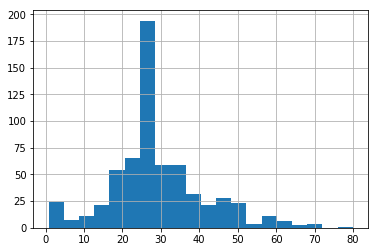

In [32]:
dftrain.age.hist(bins=20).plot()

大多数乘客的年龄为二十年代和三十年代

### 性别分布

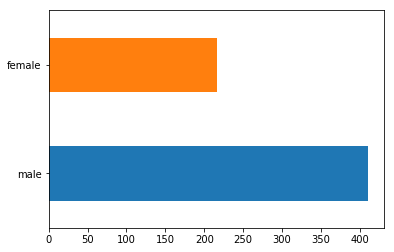

In [6]:
dftrain.sex.value_counts().plot(kind='barh')

男性乘客大约为女性乘客的两倍

### 乘客类别

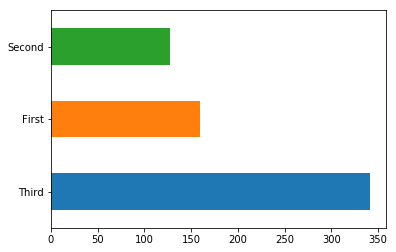

In [7]:
dftrain['class'].value_counts().plot(kind='barh')

大多数乘客为第三类别

### 登船地点

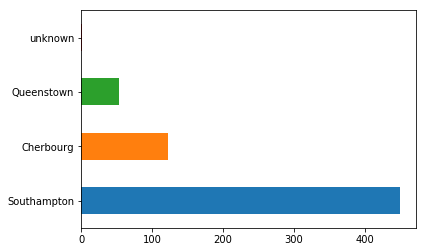

In [8]:
dftrain['embark_town'].value_counts().plot(kind='barh')

大多数乘客从Southampton登船

### 男女幸存率

Text(0.5,0,'% survive')

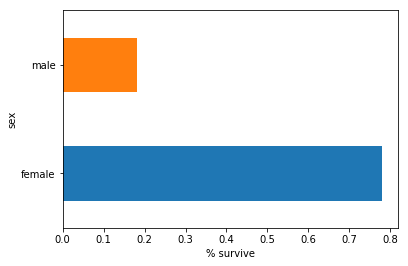

In [9]:
ax = (pd.concat([dftrain, y_train], axis=1)\
  .groupby('sex')
  .survived
  .mean()
  .plot(kind='barh'))
ax.set_xlabel('% survive')

女性的存活率高于男性，表明性别是一个很重要的特征

# 构造特征

Gradient Boosting estimator 可以处理数值型和类别型特征。
tf.feature_column为tf.estimator中的模型定义特征，并提供了one-hot,normalization,bucketization的特征处理方法。

在接下来的特征处理中，类别型特征都被转换成了one-hot编码(indicator_column)的特征。

In [10]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
  #指示列并不直接操作数据，但它可以把各种分类特征列转化成为input_layer()方法
  #接受的特征列。
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

可以通过下面的例子看一看indicator_column对class特征做了怎样的特征变换

In [11]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


查看对所有特征的变化

In [12]:
fc.input_layer(dict(example),feature_columns)

<tf.Tensor: id=328, shape=(1, 34), dtype=float32, numpy=
array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)>

In [13]:
fc.input_layer(dict(example),feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

# 创建input_fn
input function会指定模型在训练和验证时怎么读入数据。
可以使用tf.data.from_tensor_slices方法直接读取Pandas的dataframe,
该方法适合少量，可以在内存内读取的数据集。

In [14]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)  
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
# 包装方法，model.train不接受带参数的input_fn
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

# 训练和评估模型
模型的训练和评估主要有以下三个步骤：
- 模型的初始化，制定模型使用的参数和高参
- 通过train_input_fn输入函数将训练数据投入模型中，并使用model.train()方法训练模型
- 使用训练数据集dfeval来评估模型的性能，比较模型的预测值和真实值y_eval

在训练Boosted Tree模型之前，先训练一个线性模型（Logistic Regression）,在训练模型之前可以先构建一个简单模型作为基准来评价模型的性能。

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


接下来训练Boosted Tree。 tf实现了回归树(BoostedTreesRegressor)、
分类树(BoostedTreesClassifier),以及任何可以二分微分的自定义损失函数的
BoostedTreesEstimator。因为本题为分类问题，所以使用BoostedTreesClassifier

In [16]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.8181818
Dummy model:  0.625


如果数据量较小，可以放进内存，从模型训练效率的角度考虑，推荐使用boosted_trees_classifier_train_in_memory 方法，如果训练时间不需要考虑，或者数据量很大想要分布式训练，使用之前介绍的tf.estimator.BoostedTrees API 。

在使用boosted_trees_classifier_train_in_memory方法时，输入数据不应该batch,模型在整个数据集上操作。

In [ ]:
# 这块官方代码在我的本地跑还有些问题
def make_inmemory_train_input_fn(X, y):
  def input_fn():
    return dict(X), y
  return input_fn


train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
est = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(
    train_input_fn,
    feature_columns)
print(est.evaluate(eval_input_fn)['accuracy'])

模型预测

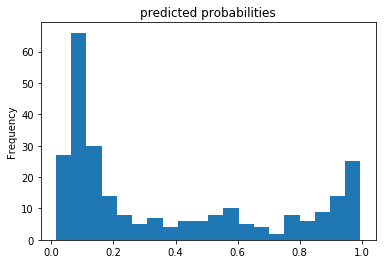

In [29]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

查看模型的ROC

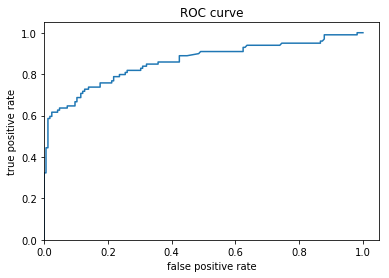

In [31]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);